In [3]:
import csv
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import kde
from matplotlib.ticker import MultipleLocator

class agent:
    def __init__(self, strategy, neighbors):
        # Current time (t)
        self.strategy = strategy # C = 1, D = 0
        self.neighbors = neighbors # List of the agent's neighbors' index

        # Next time (t+1)
        self.future_strategy = strategy
        self.future_neighbors = [n for n in self.neighbors] # deep coop

        # self.role = -1
        # self.imitate_agent = -1
        # self.imitate_strategy = -1

    def get_payoff(self, lattice):
        # total_individual_payoff = 0
        # for j in self.neighbors:            
        #     total_individual_payoff += lattice.encounter(self.strategy, lattice.agents[j].strategy)

        u = sum([lattice.agents[n].strategy for n in self.neighbors])
        s = self.strategy
        total_individual_payoff = s*u + (1-s)*u*lattice.b
        return total_individual_payoff 
                
class lattice: 
    def __init__(self, size, b, p, K=8):
        self.size = size # Number of agents / size of nerwork (N)
        self.b = b # Incentive to defect (T in PD payoff matrix)
        self.p = p # Social plasticity
        self.K = K # Average degree per agent
        self.t = 0 # Time
        self.agents = []
        self.stationary_state = False
        self.allD = False
        
        self.G = nx.gnm_random_graph(self.size, self.size*self.K/2)
        cooperator_index = random.sample(list(range(self.size)), int(self.size*0.6)) # Choose who to become a cooperator
        
        # For testing
        # lines = ["0 1 2 4", "1 0 5 ", "2 0 5", "3 4 4", "4 0 3", "5 1 2 3"]
        # self.G = nx.parse_adjlist(lines, nodetype=int)
        # cooperator_index = [0, 1, 2, 4, 5] 

        for n in range(self.size):
            if n in cooperator_index:
                self.agents.append(agent(1, list(self.G.neighbors(n)))) # C-agent
            else:
                self.agents.append(agent(0, list(self.G.neighbors(n)))) # D-agent
    
    # def encounter(self, S1, S2): # Reutrn strategy 1's payoff
    #     if S1 == 1 and S2 == 1: # C-C
    #         return 1 # R
    #     elif S1 == 1 and S2 == 0: # C-D
    #         return 0 # S
    #     elif S1 == 0 and S2 == 1: # D-C
    #         return self.b # T
    #     elif S1 == 0 and S2 == 0: # D-D
    #         return 0 # 
            
    def check_stationary_state(self):
        self.stationary_state = True
        for agent in self.agents:
            if agent.future_strategy != agent.strategy or agent.future_neighbors != agent.neighbors:
                self.stationary_state = False
                break

        strategy_set = set([n.future_strategy for n in self.agents])
        if strategy_set == {0}:
            self.allD = True

    def one_round(self):
        self.t += 1

        # Step 1: Interact
        payoff_for_each_agent = []
        for i in range(self.size):
            # payoff_for_each_agent.append(self.agents[i].get_payoff(self))
            u_i = sum([self.agents[n].strategy for n in self.agents[i].neighbors])
            s_i = self.agents[i].strategy
            total_individual_payoff = s_i*u_i + (1-s_i)*u_i*self.b
            payoff_for_each_agent.append(total_individual_payoff)
        payoff_for_each_agent = np.array(payoff_for_each_agent)

        for i in range(self.size): 
            # self.agents[i].imitate_agent = -1
            # self.agents[i].imitate_strategy = -1

            neighbors = [n for n in self.agents[i].neighbors]
            neighbors_payoff = payoff_for_each_agent[neighbors]       

            if len(neighbors) == 0:
                continue
            
            # Unsatisfied agent
            if neighbors_payoff.max() > payoff_for_each_agent[i]:         
                # Step 2: Update strategy
                neighbors_with_highest_payoff = np.where(neighbors_payoff == neighbors_payoff.max())[0]
                if len(neighbors_with_highest_payoff) > 1:
                    target = neighbors[random.choice(neighbors_with_highest_payoff)]
                else:
                    target = neighbors[neighbors_with_highest_payoff[0]]
                target_strategy = self.agents[target].strategy
                self.agents[i].future_strategy = target_strategy

                # self.agents[i].imitate_agent = target
                # self.agents[i].imitate_strategy = target_strategy
    
                # Step 3: Update neighborhood
                if target_strategy == 0: # imitate a D-agent
                    change_neighbor = random.choices([True, False], weights=[self.p, 1-self.p])[0]
                    if change_neighbor:
                        # Break link with with the imitated D neighbor
                        self.agents[i].future_neighbors.remove(target)
                        self.agents[target].future_neighbors.remove(i)
    
                        # Randomly choose partner from the whole neteork
                        candidate = list(range(self.size))
                        
                        candidate.remove(i)
                        for j in self.agents[i].future_neighbors:
                            candidate.remove(j)
                        # for j in self.agents[i].neighbors:
                        #     if j in candidate:
                        #         candidate.remove(j)

                        new_neighbor = random.choice(candidate) 
                        self.agents[i].future_neighbors.append(new_neighbor)
                        self.agents[new_neighbor].future_neighbors.append(i)
                
            #     self.agents[i].role = "Conformist"
            # else:
            #     if self.agents[i].strategy == 1:
            #         self.agents[i].role = "Leader"
            #     else:
            #         self.agents[i].role = "Exploiter"

        self.check_stationary_state()
        
        # Move to t+1
        for agent in self.agents:
            agent.strategy = agent.future_strategy
            agent.neighbors = [n for n in agent.future_neighbors] # deep copy    

        
    def get_fraction_of_cooperator(self):
        return (sum([agent.strategy for agent in self.agents]) / self.size)

    def get_average_payoff_of_cooperators(self):
        payoff_of_cooperators = [agent.get_payoff(self) for agent in self.agents if agent.strategy == 1]
        return (sum(payoff_of_cooperators) / len(payoff_of_cooperators))
    
    def get_average_payoff_of_defectors(self):
        payoff_of_defectors = [agent.get_payoff(self) for agent in self.agents if agent.strategy == 0]
        return (sum(payoff_of_defectors) / len(payoff_of_defectors))

# FIG 3.

In [2]:
random.seed(14)
np.random.seed(14)

parameters_b = [1.2, 1.4, 1.6, 1.8]
parameters_p = [0, 0.01, 0.1, 1]
trial_num = 5

outcome = [] 

for p in parameters_p:
    print(p, ":", sep="", end=" ")
    for_each_b = []
    for b in parameters_b:
        print(b, end=" ")
        trials_log = []
        for trial in range(trial_num):
            Mylattice = lattice(10000, b=b, p=p)
            if p != 0:
                while not Mylattice.stationary_state:
                    Mylattice.one_round()
                if not Mylattice.allD:
                    fc = Mylattice.get_fraction_of_cooperator()
                    trials_log.append(fc) 
            else:
                fc_log = []
                for t in range(1000):
                    Mylattice.one_round()
                    fc_log.append(Mylattice.get_fraction_of_cooperator())
                    fc = sum(fc_log[-100:])/len(fc_log[-100:])
                trials_log.append(fc) 
        for_each_b.append(sum(trials_log)/len(trials_log))
    print()
    outcome.append(for_each_b)

0: 1.2 1.4 1.6 1.8 
0.01: 1.2 1.4 1.6 1.8 
0.1: 1.2 1.4 1.6 1.8 
1: 1.2 1.4 1.6 1.8 


In [16]:
with open('data.csv', newline='') as csvfile:
  outcome = list(csv.reader(csvfile))
print(outcome)

[['0.8574529', '0.5308867000000002', '0.2493388', '0.11375539999999999'], ['0.9733700000000001', '0.8198400000000001', '0.55094', '0.0014666666666666665'], ['0.96182', '0.79616', '0.5705100000000001', '0.35011111111111115'], ['0.9738899999999999', '0.9481299999999999', '0.9300799999999999', '0.32375']]


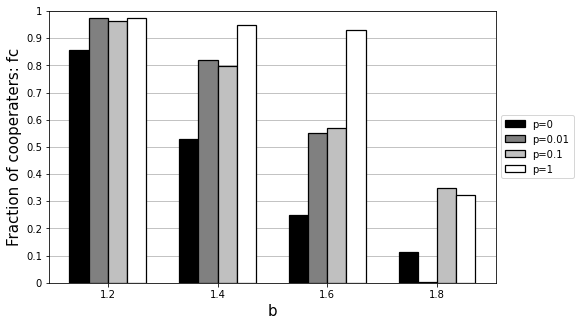

In [115]:
x = np.array([1.2, 1.4, 1.6, 1.8])
p_0 = [float(o) for o in outcome[0]]
p_1 = [float(o) for o in outcome[1]]
p_2 = [float(o) for o in outcome[2]]
p_3 = [float(o) for o in outcome[3]]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

width = 0.035
plt.bar(x + width*0, p_0, width, edgecolor='black', linewidth='1.25', color='black', label='p=0')
plt.bar(x + width*1, p_1, width, edgecolor='black', linewidth='1.25', color='grey', label='p=0.01')
plt.bar(x + width*2, p_2, width, edgecolor='black', linewidth='1.25', color='silver', label='p=0.1')
plt.bar(x + width*3, p_3, width, edgecolor='black', linewidth='1.25', color='white', label='p=1')

plt.ylim(0, 1)
plt.xticks(x + width*1.5, x)
ax.set_yticks(np.arange(0, 1.01, step=0.1))
ax.set_xlabel("b", fontsize=15)
ax.set_ylabel("Fraction of cooperaters: fc", rotation=90, y=0.5, fontsize=15)
ax.set_axisbelow(True)
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
fig.set_facecolor('white')

lg = plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.grid(axis='y', linewidth=.75)

plt.savefig('FIG3.png', bbox_extra_artists=(lg,), bbox_inches='tight')
plt.show()   

In [7]:
data_file_path = 'data.csv'
with open(data_file_path, 'w', newline='') as output_file:
    writer = csv.writer(output_file)
    for data in outcome:   
        writer.writerow(data)

# FIG 4.

In [1]:
random.seed(14)
np.random.seed(14)

parameter_b = np.arange(1, 2, 0.05)
trial_num = 10

# p = 0
p_0 = []
for b in parameter_b:
    print(f'{b:.2f}', end=" ")
    trial_log = []
    for trial in range(trial_num):
        Mylattice = lattice(10000, b=b, p=0)
        for round in range(5):
            Mylattice.one_round()
        apc = Mylattice.get_average_payoff_of_cooperators()
        apd = Mylattice.get_average_payoff_of_defectors()
        trial_log.append(apd-apc)

    p_0.append(sum(trial_log)/len(trial_log))
print()


# p = 0.1
trial_num = 1
p_zero_point_1 = []
for b in parameter_b:
    print(f'{b:.2f}', end=" ")
    trial_log = []
    trial_counter = 0
    while trial_counter < trial_num:
        Mylattice = lattice(10000, b=b, p=0.1)
        while not Mylattice.stationary_state:
            Mylattice.one_round()

        if not Mylattice.allD:
            apc = Mylattice.get_average_payoff_of_cooperators()
            apd = Mylattice.get_average_payoff_of_defectors()
            trial_log.append(apd-apc)
            
            trial_counter += 1

    p_zero_point_1.append(sum(trial_log)/len(trial_log))

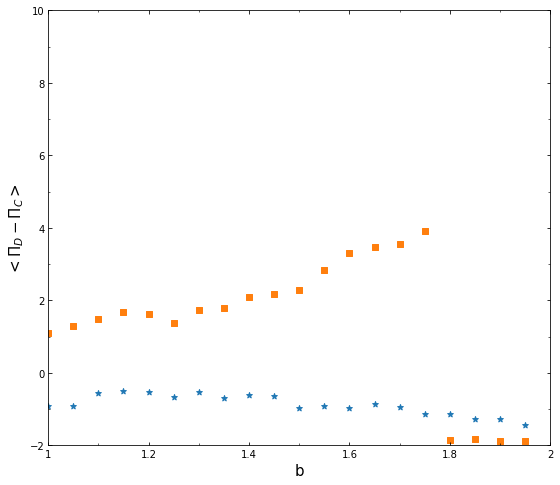

In [225]:

fig, ax = plt.subplots(1, 1, figsize=(9, 8))

plt.scatter(parameter_b, p_0, marker='*') 
plt.scatter(parameter_b, p_zero_point_1, marker='s') 

ax.set_xlim([1, 2])
ax.set_ylim([-2, 10])
ax.set_xticks([1, 1.2, 1.4, 1.6, 1.8, 2])
ax.set_yticks([-2, 0, 2, 4, 6, 8, 10])
ax.set_xlabel("b", y=0.5, fontsize=15)
ax.set_ylabel(r'$<\Pi_D - \Pi_C>$', rotation=90, y=0.5, fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.tick_params(which='both', direction='in', right=True, top=True)
fig.set_facecolor('white')

# plt.savefig('FIG4.jpg')
plt.show() 

In [5]:
# Save data
data_file_path = 'data2.csv'
with open(data_file_path, 'w', newline='') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(p_0)
    writer.writerow(p_zero_point_1)

NameError: name 'p_0' is not defined

# FIG 5.

In [64]:
random.seed(626)
np.random.seed(626)

Mylattice = lattice(10000, b=1.7, p=0)
log = []
round_num = 1000
for i in range(round_num):
    Mylattice.one_round()
    log.append(Mylattice.get_fraction_of_cooperator())

    if i == 200:
        Mylattice.p = 1
    
    if i == 500:
        payoff_of_each_agent = np.array([agent.get_payoff(Mylattice) for agent in Mylattice.agents])
        absolute_leader = payoff_of_each_agent.argmax()
        Mylattice.agents[absolute_leader].strategy = 0

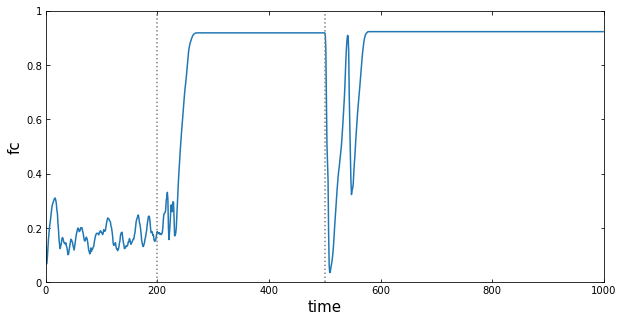

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(log)

ax.set_xlim([0, 1000])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylabel("fc", rotation=90, y=0.5, fontsize=15)
ax.set_xlabel("time", y=0.5, fontsize=15)
ax.axvline(200, 0, 1, color='grey', linestyle=':')
ax.axvline(500, 0, 1, color='grey', linestyle=':')
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.rstrip('0').rstrip('.'))
ax.tick_params(direction='in', right=True, top=True)

fig.set_facecolor('white')
plt.savefig('FIG5.jpg')
plt.show() 

# Testing

0 
459
80000
False
0.4586


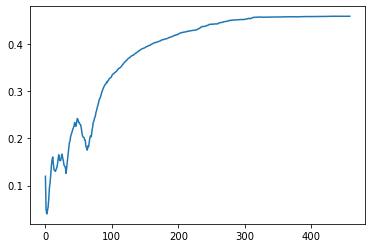

In [80]:
# random.seed(14)
# np.random.seed(14)

# Mylattice = lattice(10000, b=1.75, p=0.1)
# print(sum([len(i.neighbors) for i in Mylattice.agents]))
# log = []

round_num = 1000
for i in range(round_num):
    if i % 10 == 0:
        print(i, end=" ")

    Mylattice.one_round()
    log.append(Mylattice.get_fraction_of_cooperator())
    
    if Mylattice.stationary_state == True:
        print("\n", Mylattice.t, sep="")
        break

print(sum([len(i.neighbors) for i in Mylattice.agents]), sep="")
print(Mylattice.allD)
print(log[-1])
plt.plot(log)

In [9]:
# random.seed(14)
# np.random.seed(14)

# Mylattice = lattice(10000, b=1.85, p=0.1)
# log = []

# Mylattice.stationary_state = False

# while not Mylattice.stationary_state:
#     Mylattice.one_round()
#     log.append(Mylattice.get_fraction_of_cooperator())

#     t = Mylattice.t
#     if t % 100 == 0:
#         print(t, end=" ")
#         # plt.plot(log)
#         # plt.show()

#     if Mylattice.stationary_state:
#         print("!", Mylattice.t)

# # print(Mylattice.t)
# plt.plot(log)
# print(log[-1])

1.8621544937363517
0.0056


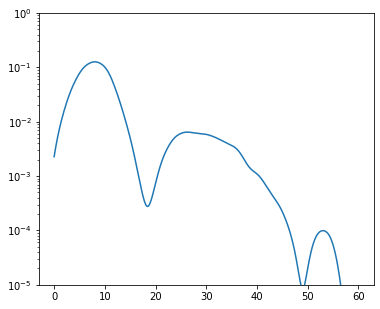

In [219]:
def normalize(probs):
    prob_factor = 1 / sum(probs)
    return [prob_factor * p for p in probs]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

payoff_of_C = normalize(np.array([agent.get_payoff(Mylattice) for agent in Mylattice.agents if agent.strategy == 1]))
# payoff_of_D = normalize(np.array([agent.get_payoff(Mylattice) for agent in Mylattice.agents if agent.strategy == 0]))

payoff_of_C = np.array([agent.get_payoff(Mylattice)*2 for agent in Mylattice.agents if agent.strategy == 1])
payoff_of_D = np.array([agent.get_payoff(Mylattice) for agent in Mylattice.agents if agent.strategy == 0])

density = kde.gaussian_kde(payoff_of_C)
x = np.linspace(0, 60, 500)
y = density(x)

ax.set_yscale('log')
ax.set_ylim([10**-5, 1])
# ax.set_yticks([1, 10**-1, 10**-2, 10**-3, 10**-4, 10*-5])
# fig.set_facecolor('white')
plt.plot(x, y)
plt.show()

In [93]:
# print(Mylattice.stationary_state)

# for i, agent in enumerate(Mylattice.agents):
#     if agent.strategy == 1 and i <= 10:
#         agent = Mylattice.agents[i]
#         for n in agent.neighbors:
#             print((Mylattice.agents[n].strategy, Mylattice.agents[n].get_payoff(Mylattice)), end=", ")
#         print()
#         # imitate_chain = [(agent.role, agent.get_payoff(Mylattice), agent.imitate_agent)]
#         # imitate_agent =  Mylattice.agents[agent.imitate_agent]
#         # if agent.imitate_agent != -1:
#         #     while imitate_agent.role != "Leader" and imitate_agent.imitate_agent != -1:
#         #         next = imitate_agent.imitate_agent
#         #         imitate_agent = Mylattice.agents[next]
#         #         imitate_chain.append((imitate_agent.role, imitate_agent.get_payoff(Mylattice), imitate_agent.imitate_agent))
#         # print(i, imitate_chain)

# print('-'*10)

# Mylattice.one_round()
# print(Mylattice.stationary_state)

# for i, agent in enumerate(Mylattice.agents):
#     if agent.strategy == 1 and i <= 10:
#         agent = Mylattice.agents[i]
#         for n in agent.neighbors:
#             print((Mylattice.agents[n].strategy, Mylattice.agents[n].get_payoff(Mylattice)), end=", ")
#         print()

# print('-'*10)

# Mylattice.one_round()
# print(Mylattice.stationary_state)

# for i, agent in enumerate(Mylattice.agents):
#     if i == 0:
#         agent = Mylattice.agents[i]
#         imiitate_agent = Mylattice.agents[i].imitate_agent
#         neighbors = []
#         neighbors_s = []
#         neighbors_p = []
#         for n in agent.neighbors:
#             neighbors.append(n)
#             neighbors_s.append(Mylattice.agents[n].strategy)
#             neighbors_p.append(Mylattice.agents[n].get_payoff(Mylattice))
#         print(agent.strategy, imiitate_agent, Mylattice.agents[imiitate_agent].strategy , neighbors, neighbors_s, neighbors_p, '-'*10,sep="\n")

False
0
9856
0
[9749, 962, 8045, 6054, 3038, 9856, 7864]
[0, 0, 0, 0, 0, 0, 0]
[1.8, 3.6, 0.0, 0.0, 1.8, 3.6, 0.0]
----------
False
0
9856
0
[9749, 962, 8045, 6054, 3038, 9856, 7864]
[0, 0, 0, 0, 0, 0, 0]
[5.4, 3.6, 0.0, 0.0, 1.8, 1.8, 0.0]
----------


In [144]:
print(sum([len(i.neighbors) for i in Mylattice.agents]))

for i in Mylattice.agents:
    if len(set(i.neighbors)) != len(i.neighbors):
        print("!", i.neighbors)
    for j in i.neighbors:
        if i in Mylattice.agents[j].neighbors:
            print("#")
        
sum(log[-100:])/len(log[-100:])

80000


0.41378000000000004